In [4]:
import tensorflow as _tf

In [34]:
_MAG_PATH = 'trained_models/mag/trained_model.ckpt-1000.meta'

with _tf.Graph().as_default() as graph:
    with _tf.Session() as sess:

        # restore saved graph and tensor values
        saver = _tf.train.import_meta_graph(_MAG_PATH)
        
        input_graph_def = graph.as_graph_def()
        saver.restore(sess, _MAG_PATH[:-5])
        

        output_node_names= 'predictions/ArgMax'
        output_graph_def = _tf.graph_util.convert_variables_to_constants(
                    sess, # The session
                    input_graph_def, # input_graph_def is useful for retrieving the nodes 
                    output_node_names.split(","))
        
        output_graph = "test_mag_frozen.pb"
        with _tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())

#         sess.close()

INFO:tensorflow:Restoring parameters from trained_models/mag/trained_model.ckpt-1000
INFO:tensorflow:Froze 74 variables.
Converted 74 variables to const ops.


In [25]:
frozen_graph="test_sign_frozen.pb"

with _tf.gfile.GFile(frozen_graph, "rb") as f:
    restored_graph_def = _tf.GraphDef()
    restored_graph_def.ParseFromString(f.read())
    
with _tf.Graph().as_default() as graph:
    _tf.import_graph_def(
        restored_graph_def,
        input_map=None,
        return_elements=None,
        name="")

In [26]:
sample_keep_prob = graph.get_tensor_by_name('keep_probs/sample_keep_prob:0')
conv_keep_prob = graph.get_tensor_by_name('keep_probs/conv_keep_prob:0')
is_training = graph.get_tensor_by_name('is_training:0')
X = graph.get_tensor_by_name('sample/X:0')

In [27]:


# add hook to output operation
pred_cls = graph.get_tensor_by_name('predictions/ArgMax:0')

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import hera_cal
import pyuvdata

## Estimating the cable delay for a redundant visibility ratio

 Load data

In [14]:
uvd = pyuvdata.UVData()

# data
miriad_path = '../../zen_data/zen.2458098.58037.xx.HH.uv'
uvd.read_miriad(miriad_path)

# get the redundant baselines for that data
aa = hera_cal.utils.get_aa_from_uv(uvd)
info = hera_cal.omni.aa_to_info(aa)
red_bls = np.array(info.get_reds())

From one redundant baseline select two unique separations

In [15]:
red_bl = red_bls[np.random.randint(len(red_bls))]
two_seps = [random.sample(red_bl, 2)][0]  
two_seps

[(36, 55), (66, 87)]

Get data for those separations 

In [16]:
data = {}
for sep in two_seps:
    data[sep] = uvd.get_data(sep)

Construct visibility ratio

In [17]:
V = data[two_seps[0]] * data[two_seps[1]].conjugate()

Take a look

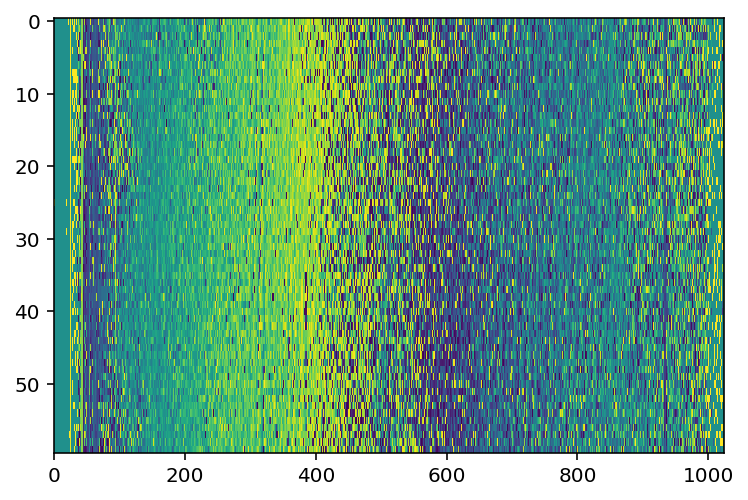

In [18]:
plt.imshow(np.angle(V), aspect = 'auto');

In [20]:
inputs = (np.array(V) + np.pi) / (2. * np.pi)

In [28]:

feed_dict = {sample_keep_prob : 1.,
             conv_keep_prob : 1.,
             is_training : False,
             X: inputs}

# collect prediction
_pred_cls = sess.run(pred_cls, feed_dict = feed_dict)

RuntimeError: Attempted to use a closed Session.

In [35]:
frozen_graph="test_mag_frozen.pb"


with _tf.gfile.GFile(frozen_graph, "rb") as f:
    restored_graph_def = _tf.GraphDef()
    restored_graph_def.ParseFromString(f.read())

with _tf.Graph().as_default() as graph:
    _tf.import_graph_def(
        restored_graph_def,
        input_map=None,
        return_elements=None,
        name="")

    sample_keep_prob = graph.get_tensor_by_name('keep_probs/sample_keep_prob:0')
    conv_keep_prob = graph.get_tensor_by_name('keep_probs/conv_keep_prob:0')
    is_training = graph.get_tensor_by_name('is_training:0')
    X = graph.get_tensor_by_name('sample/X:0')

    # add hook to output operation
    pred_cls = graph.get_tensor_by_name('predictions/ArgMax:0')

with _tf.Session(graph=graph) as sess:
    feed_dict = {sample_keep_prob : 1.,
                 conv_keep_prob : 1.,
                 is_training : False,
                 X: np.angle(inputs).reshape(-1,1,1024,1)}

    # collect prediction
    _pred_cls = sess.run(pred_cls, feed_dict = feed_dict)

    sess.close()

In [36]:
_pred_cls

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])